## 1 Dim RL Agent

-----


In [1]:
import numpy as np
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

import src

Target

In [2]:
target = tf.constant([0, 0, 0.1], dtype=tf.float32)

Defining initial time and state:

In [3]:
from astropy.time import Time
time = Time("2000-01-01 00:00", scale="utc")
walker_name = "test"

walker_position = np.array([0, 0, 0])
walker_velocity = np.array([0, 0, 0])

# walker_position, walker_velocity = src.get_body_state("mars", time).values()

#### Hyperparameters and Environment
------

In [4]:
agent_type = ["DQN", "PPO"][1]
dqn_batch_size = 32
env_batch_size = 1

max_boost = 1e-4
reward_per_step = - 1.
reward_factor_boost = 0.  # 0.1 / max_boost
reward_factor_target_distance = - 10.
reward_per_step_near_target = 1.
near_target_window = 0.01
class Env(
    src.env.WalkerSystemEnv,
    src.env.OneDimDiscreteAction,               # src.env: ContinuousAction, DiscreteAction, OneDimDiscreteAction
    src.env.StateAndDiffObservation,            # src.env: StateAndDiffObservation, GravityObservation, AllPositionsObservation
    src.env.DistanceAndTargetReached            # src.env: ContinuousDistance, TargetReached, DistanceAndTargetReached
): ...

epsilon_greedy_p = 0.1 # DQN
fc_layer_params = (64, 64)
learning_rate = 1e-4

train_steps = 2000
episodes_per_train_step = 1
episodes_per_eval_step = 1

log_interval = 50

max_episode_length = 50
system_step_size = 2

if agent_type in ["PPO"]:
    replay_buffer_capacity = (
        episodes_per_train_step * 
        env_batch_size * 
        max_episode_length 
        + 10
    )
if agent_type in ["DQN"]:
    replay_buffer_capacity = 10000

In [5]:
from tf_agents.environments import ActionClipWrapper
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.agents import PPOAgent
from tf_agents.agents import DqnAgent
from tf_agents.networks.q_network import QNetwork
from tf_agents.metrics.tf_metrics import AverageReturnMetric
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.utils.common import function

from keras.optimizers import Adam
from keras import layers

Batched Environment for Training

In [6]:
system = src.SunSystem(["earth"], initial_time=time, add_sun=False)
system.set_smooth = 1e-9
walker = src.Walker(walker_position, walker_velocity, mass=1., name=walker_name)
solver = src.Solver()

In [7]:
env = Env(
    walker, system, solver, target, 
    max_iters=max_episode_length, 
    step_size=system_step_size,
    reward_factor_boost=reward_factor_boost,
    reward_per_step=reward_per_step,
    reward_factor_target_distance=reward_factor_target_distance,
    reward_per_step_near_target=reward_per_step_near_target,
    max_boost=max_boost,
)

tf_env = src.env_wrappers.tfpy_env_wrapper(env)

Easily Acessible Eval Env for evaluation:

In [8]:
print('Observation Spec:')
print(tf_env.observation_spec())

print('\nAction Spec:')
print(tf_env.action_spec())

print('\nBatch Size:')
print(tf_env.batch_size)

Observation Spec:
{'walker-state': TensorSpec(shape=(6,), dtype=tf.float32, name='walker-state'), 'diff-to-target': TensorSpec(shape=(3,), dtype=tf.float32, name='target')}

Action Spec:
BoundedTensorSpec(shape=(), dtype=tf.int32, name='boost-direction', minimum=array(0), maximum=array(2))

Batch Size:
1


#### Agent and Policies
-----

In [9]:
optimizer = Adam(learning_rate=learning_rate)

obs_specs = tf_env.observation_spec()

pre_layers = {k: layers.Flatten() for k in obs_specs}
pre_combiner = layers.Concatenate(axis=-1)

In [10]:
if agent_type == "PPO":

    actor_net = ActorDistributionNetwork(
        input_tensor_spec=obs_specs,
        output_tensor_spec=tf_env.action_spec(),
        preprocessing_layers=pre_layers,    # Must be of the same type (dict in this case) as `input_tensor_spec`
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params
    )

    value_net = ValueNetwork(
        obs_specs,
        preprocessing_layers=pre_layers,
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params
    )

    tf_agent = PPOAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        actor_net=actor_net,
        value_net=value_net,
        optimizer=optimizer,
    )

    tf_agent.initialize()

In [11]:
if agent_type == "DQN":
    # https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial
    from tf_agents.utils.common import element_wise_squared_loss
    
    q_net = QNetwork(
        input_tensor_spec=obs_specs,
        action_spec=tf_env.action_spec(),
        preprocessing_layers=pre_layers,
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params,
    )
    
    tf_agent = DqnAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        q_network=q_net,
        epsilon_greedy=epsilon_greedy_p,
        td_errors_loss_fn=element_wise_squared_loss,
        optimizer=optimizer
    )

    tf_agent.initialize()

#### Metrics
-----

In [12]:
trn_return_observer = AverageReturnMetric(batch_size=tf_env.batch_size)
evl_return_observer = AverageReturnMetric(batch_size=tf_env.batch_size)

#### Replay Buffer

-----

In [13]:
replay_buffer = TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity
)

#### Drivers

-----

In [14]:
trn_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.collect_policy,
    observers=[replay_buffer.add_batch, trn_return_observer],
    num_episodes=episodes_per_train_step
)

evl_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.policy,
    observers=[evl_return_observer],
    num_episodes=episodes_per_eval_step
)

#### Testing Setup

----

In [15]:
initial_time_step = tf_env.reset()
_ = evl_driver.run(initial_time_step)

initial_time_step = tf_env.reset()
for _ in range(max_episode_length):
    action = 0
    time_step = tf_env.step(action)

In [16]:
plotter = src.Plotter(env=tf_env)
plotter.draw("3d", zrange=None)

In [17]:
if agent_type in ["PPO"]:
    initial_time_step = tf_env.reset()
    policy_state = tf_agent.collect_policy.get_initial_state(tf_env.batch_size)
    _, policy_state = trn_driver.run(initial_time_step, policy_state)
    # replay_buffer.gather_all()

if agent_type in ["DQN"]:
    initial_time_step = tf_env.reset()
    _, policy_state = trn_driver.run(initial_time_step)
    data = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=dqn_batch_size,
        num_steps=2).prefetch(3)

In [18]:
plotter = src.Plotter(env=tf_env)
plotter.draw("3d", zrange=None)

In [19]:
replay_buffer.clear()

#### Training Loop
----

In [20]:
# Speeing up:
trn_driver.run = function(trn_driver.run)
evl_driver.run = function(evl_driver.run)
tf_agent.train = function(tf_agent.train)

In [21]:
from tqdm import tqdm

losses = []
rewards = []

policy_state = tf_agent.collect_policy.get_initial_state(tf_env.batch_size)

evl_returns = []
trn_returns = []
losses = []

for n_episode in tqdm(range(train_steps+1)):

    # Eval Returns (before next training step)
    initial_time_step = tf_env.reset()
    _ = evl_driver.run(initial_time_step)
    evl_return = evl_return_observer.result().numpy()
    evl_returns.append(evl_return)

    # Train Step
    initial_time_step = tf_env.reset()
    _, policy_state = trn_driver.run(initial_time_step, policy_state)

    if agent_type != "DQN":
        trajectories = replay_buffer.gather_all()
        
    if agent_type == "DQN":
        data = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=dqn_batch_size,
            num_steps=2).prefetch(3)
        trajectories, _ = next(iter(data))
        

    train_loss = tf_agent.train(experience=trajectories)  
    loss = train_loss.loss.numpy()
    losses.append(loss)

    # Clearing Buffer
    replay_buffer.clear()

    # Train Returns
    trn_return = trn_return_observer.result().numpy()
    trn_returns.append(trn_return)

    # Logging
    if n_episode % log_interval == 0:
        print(f"\nEposide {n_episode}:")
        print(f"- Train Average Return = {trn_return:.2f}")
        print(f"- Eval Average Return  = {evl_return:.2f}")
        print(f"- Loss                 = {loss:.2f}")

  0%|          | 0/2001 [00:00<?, ?it/s]

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


  0%|          | 1/2001 [00:18<10:01:15, 18.04s/it]


Eposide 0:
- Train Average Return = 11.02
- Eval Average Return  = 6.83
- Loss                 = 13138.40


  3%|▎         | 51/2001 [01:02<28:14,  1.15it/s]  


Eposide 50:
- Train Average Return = 5.75
- Eval Average Return  = 6.83
- Loss                 = 159.27


  5%|▌         | 101/2001 [01:47<27:01,  1.17it/s]


Eposide 100:
- Train Average Return = 8.44
- Eval Average Return  = 8.93
- Loss                 = 182.13


  8%|▊         | 151/2001 [02:30<26:07,  1.18it/s]


Eposide 150:
- Train Average Return = 9.65
- Eval Average Return  = 9.45
- Loss                 = 130.07


 10%|█         | 201/2001 [03:13<25:33,  1.17it/s]


Eposide 200:
- Train Average Return = 11.50
- Eval Average Return  = 13.45
- Loss                 = 106.22


 13%|█▎        | 251/2001 [03:57<27:05,  1.08it/s]


Eposide 250:
- Train Average Return = 11.68
- Eval Average Return  = 16.23
- Loss                 = 135.53


 15%|█▌        | 301/2001 [04:41<24:50,  1.14it/s]


Eposide 300:
- Train Average Return = 8.15
- Eval Average Return  = 6.83
- Loss                 = 43.89


 18%|█▊        | 351/2001 [05:25<25:31,  1.08it/s]


Eposide 350:
- Train Average Return = 14.44
- Eval Average Return  = 6.83
- Loss                 = 109.66


 20%|██        | 401/2001 [06:08<23:14,  1.15it/s]


Eposide 400:
- Train Average Return = 8.29
- Eval Average Return  = 6.83
- Loss                 = 50.99


 23%|██▎       | 451/2001 [06:53<19:40,  1.31it/s]


Eposide 450:
- Train Average Return = 9.84
- Eval Average Return  = 9.11
- Loss                 = 215.53


 25%|██▌       | 501/2001 [07:31<18:35,  1.34it/s]


Eposide 500:
- Train Average Return = 10.82
- Eval Average Return  = 6.83
- Loss                 = 73.80


 28%|██▊       | 551/2001 [08:09<19:12,  1.26it/s]


Eposide 550:
- Train Average Return = 8.39
- Eval Average Return  = 18.75
- Loss                 = 58.02


 30%|███       | 601/2001 [08:47<17:49,  1.31it/s]


Eposide 600:
- Train Average Return = 12.27
- Eval Average Return  = 13.92
- Loss                 = 42.19


 33%|███▎      | 651/2001 [09:25<16:38,  1.35it/s]


Eposide 650:
- Train Average Return = 15.93
- Eval Average Return  = 16.16
- Loss                 = 137.11


 35%|███▌      | 701/2001 [10:02<15:50,  1.37it/s]


Eposide 700:
- Train Average Return = 11.74
- Eval Average Return  = 16.79
- Loss                 = 292.16


 38%|███▊      | 751/2001 [10:40<17:44,  1.17it/s]


Eposide 750:
- Train Average Return = 9.05
- Eval Average Return  = 19.57
- Loss                 = 63.40


 40%|████      | 801/2001 [11:22<14:32,  1.37it/s]


Eposide 800:
- Train Average Return = 8.96
- Eval Average Return  = 17.90
- Loss                 = 32.39


 43%|████▎     | 851/2001 [11:59<14:08,  1.36it/s]


Eposide 850:
- Train Average Return = 10.04
- Eval Average Return  = 18.97
- Loss                 = 23.97


 45%|████▌     | 901/2001 [12:37<15:04,  1.22it/s]


Eposide 900:
- Train Average Return = 8.68
- Eval Average Return  = 19.41
- Loss                 = 67.35


 48%|████▊     | 951/2001 [13:14<12:46,  1.37it/s]


Eposide 950:
- Train Average Return = 7.97
- Eval Average Return  = 14.96
- Loss                 = 68.92


 50%|█████     | 1001/2001 [13:50<12:12,  1.37it/s]


Eposide 1000:
- Train Average Return = 13.04
- Eval Average Return  = 19.41
- Loss                 = 317.65


 53%|█████▎    | 1051/2001 [14:27<11:39,  1.36it/s]


Eposide 1050:
- Train Average Return = 14.61
- Eval Average Return  = 16.67
- Loss                 = 13.26


 55%|█████▌    | 1101/2001 [15:07<11:54,  1.26it/s]


Eposide 1100:
- Train Average Return = 12.18
- Eval Average Return  = 6.83
- Loss                 = 67.52


 58%|█████▊    | 1151/2001 [15:50<12:39,  1.12it/s]


Eposide 1150:
- Train Average Return = 8.21
- Eval Average Return  = 6.83
- Loss                 = 73.75


 60%|██████    | 1201/2001 [16:34<10:53,  1.22it/s]


Eposide 1200:
- Train Average Return = 7.48
- Eval Average Return  = 6.83
- Loss                 = 27.21


 63%|██████▎   | 1251/2001 [17:18<12:17,  1.02it/s]


Eposide 1250:
- Train Average Return = 14.98
- Eval Average Return  = 9.91
- Loss                 = 26.83


 65%|██████▌   | 1301/2001 [18:01<09:55,  1.18it/s]


Eposide 1300:
- Train Average Return = 16.63
- Eval Average Return  = 18.52
- Loss                 = 57.88


 68%|██████▊   | 1351/2001 [18:44<11:24,  1.05s/it]


Eposide 1350:
- Train Average Return = 11.64
- Eval Average Return  = 16.99
- Loss                 = 37.54


 70%|███████   | 1401/2001 [19:33<09:49,  1.02it/s]


Eposide 1400:
- Train Average Return = 15.85
- Eval Average Return  = 18.30
- Loss                 = 37.24


 73%|███████▎  | 1451/2001 [20:21<08:36,  1.07it/s]


Eposide 1450:
- Train Average Return = 16.35
- Eval Average Return  = 16.67
- Loss                 = 28.77


 75%|███████▌  | 1501/2001 [21:11<08:11,  1.02it/s]


Eposide 1500:
- Train Average Return = 17.34
- Eval Average Return  = 18.03
- Loss                 = 24.79


 78%|███████▊  | 1551/2001 [22:01<07:39,  1.02s/it]


Eposide 1550:
- Train Average Return = 18.41
- Eval Average Return  = 16.95
- Loss                 = 5.96


 80%|████████  | 1601/2001 [22:49<06:32,  1.02it/s]


Eposide 1600:
- Train Average Return = 12.61
- Eval Average Return  = 18.08
- Loss                 = 29.12


 83%|████████▎ | 1651/2001 [23:39<05:44,  1.02it/s]


Eposide 1650:
- Train Average Return = 17.83
- Eval Average Return  = 18.03
- Loss                 = 35.92


 85%|████████▌ | 1701/2001 [24:29<04:54,  1.02it/s]


Eposide 1700:
- Train Average Return = 14.57
- Eval Average Return  = 19.72
- Loss                 = 60.19


 88%|████████▊ | 1751/2001 [25:20<03:53,  1.07it/s]


Eposide 1750:
- Train Average Return = 17.02
- Eval Average Return  = 18.08
- Loss                 = 7.65


 90%|█████████ | 1801/2001 [26:09<03:29,  1.05s/it]


Eposide 1800:
- Train Average Return = 14.45
- Eval Average Return  = 18.03
- Loss                 = 3.17


 93%|█████████▎| 1851/2001 [26:59<02:28,  1.01it/s]


Eposide 1850:
- Train Average Return = 12.47
- Eval Average Return  = 19.41
- Loss                 = 46.30


 95%|█████████▌| 1901/2001 [27:48<01:41,  1.01s/it]


Eposide 1900:
- Train Average Return = 14.32
- Eval Average Return  = 15.30
- Loss                 = 11.66


 98%|█████████▊| 1951/2001 [28:35<00:43,  1.14it/s]


Eposide 1950:
- Train Average Return = 14.65
- Eval Average Return  = 16.44
- Loss                 = 11.92


100%|██████████| 2001/2001 [29:23<00:00,  1.13it/s]


Eposide 2000:
- Train Average Return = 14.51
- Eval Average Return  = 12.33
- Loss                 = 6.38


#### Return History

----

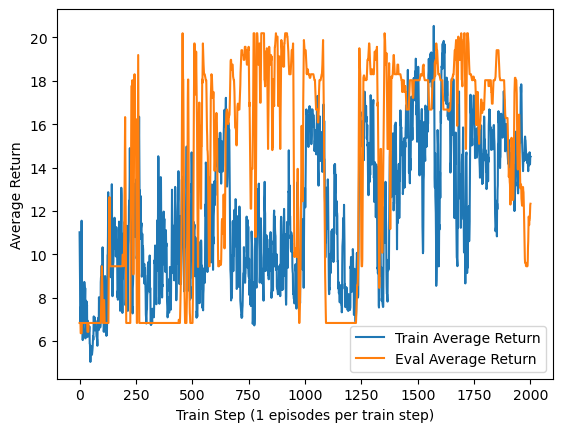

In [22]:
import matplotlib.pyplot as plt

plt.plot(trn_returns, label="Train Average Return")
plt.plot(evl_returns, label="Eval Average Return")
plt.ylabel("Average Return")
plt.xlabel(f"Train Step ({episodes_per_train_step} episodes per train step)")
plt.legend()
plt.show()

#### Visualizing Policy Execution

-----

In [23]:
time_step = tf_env.reset()
_ = evl_driver.run(time_step)

In [24]:
plotter = src.Plotter(env=tf_env)
plotter.draw("3d", zrange=None)